In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

import sys
sys.path.append('../')
from src.models.agg_catboost import agg_catboost

import os
import warnings
warnings.filterwarnings("ignore") 

from datetime import datetime, date
from IPython.display import display, Markdown

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_pickle('../data/processed/cleaned_intersections_collisions.pkl')

In [3]:
model_df = df[['COMPKEY', 'LOCATION', 'ARTERIALCLASSCD', 'SIGNAL_TYPE']]

In [4]:
num_collisions = pd.DataFrame(model_df.COMPKEY.value_counts()).reset_index().rename(columns={'index':'COMPKEY','COMPKEY':'num_collisions'})
model_df = model_df[~model_df.duplicated()]

In [5]:
model_df = model_df.merge(num_collisions, on='COMPKEY')

In [6]:
model_df.pop('COMPKEY')

0        29797.0
1        29540.0
2        35721.0
3        31913.0
4        24398.0
          ...   
7840     27583.0
7841     27535.0
7842     23960.0
7843     37572.0
7844    336131.0
Name: COMPKEY, Length: 7845, dtype: float64

In [7]:
model_df.dropna(inplace=True)
model_df['ARTERIALCLASSCD'] = model_df['ARTERIALCLASSCD'].astype(int)

In [8]:
y = model_df.pop('num_collisions')

In [9]:
feats = ['LOCATION', 'ARTERIALCLASSCD', 'SIGNAL_TYPE']

clf = agg_catboost(model_df, y, feats)
clf.train_model()

'Training on 5 k-folds complete'

In [10]:
clf.print_metrics(round_=True)

base_mse: 293.4, actual: 179.424 
 feature_importances: [0.0, 32.08, 67.92]

base_mse: 240.1, actual: 119.181 
 feature_importances: [0.0, 34.23, 65.77]

base_mse: 242.502, actual: 142.266 
 feature_importances: [0.0, 33.72, 66.28]

base_mse: 197.326, actual: 102.283 
 feature_importances: [0.0, 28.73, 71.27]

base_mse: 216.249, actual: 121.958 
 feature_importances: [0.0, 30.86, 69.14]



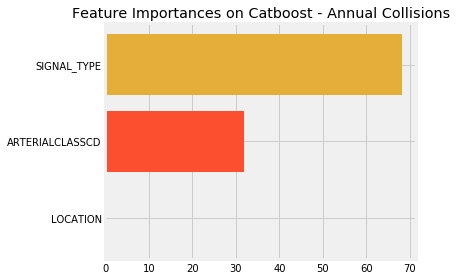

In [11]:
clf.plot_feature_importances('Feature Importances on Catboost - Annual Collisions')

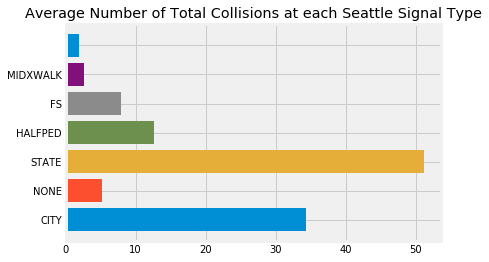

In [12]:
signal_types = [signal_type for signal_type in model_df.SIGNAL_TYPE.unique()]
collisions = [y[model_df.SIGNAL_TYPE == signal_type].mean() for signal_type in signal_types]

fig, ax = plt.subplots()
for st, col in zip(signal_types, collisions):
    ax.barh(st, col);
ax.set_title('Average Number of Total Collisions at each Seattle Signal Type');